In [1]:
from summit.domain import *
from summit.utils.dataset import DataSet

from reaction_datasets import BenchmarkDataframe

# build a dataset from benchmark dataframe

bdf = BenchmarkDataframe.ds_4()
domain = Domain()
for v in bdf.continuous_params:
    vals = bdf.df[v].tolist()
    domain += ContinuousVariable(name=v, description=v, bounds=[min(vals), max(vals)])
for v in bdf.categorical_params:
    vals = bdf.df[v].tolist()
    domain += CategoricalVariable(name=v, description=v, levels=list(set(vals)))
for v in bdf.targets:
    vals = bdf.df[v].tolist()
    domain += ContinuousVariable(name=v, description=v, bounds=[0, 100], is_objective=True, maximize=True)  # yield

dataset = DataSet.from_df(bdf.df[bdf.continuous_params + bdf.categorical_params + bdf.targets].dropna(axis=0))

In [2]:
# train an emulator
from summit.benchmarks import ExperimentalEmulator

exp = ExperimentalEmulator(model_name=bdf.name, domain=domain, dataset=dataset)
exp.train(max_epochs=1000, cv_folds=5, random_state=42, test_size=0.2, verbose=1)
exp.save("./expt_emu_ds4")


  epoch    train_loss     dur
-------  ------------  ------
      1        1.0154  3.2965
      2        0.9351  0.0240
      3        0.8742  0.0232
      4        0.8241  0.0234
      5        0.7813  0.0234
      6        0.7437  0.0205
      7        0.7101  0.0330
      8        0.6798  0.0218
      9        0.6523  0.0284
     10        0.6271  0.0426
     11        0.6040  0.0161
     12        0.5828  0.0485
     13        0.5631  0.0179
     14        0.5450  0.0215
     15        0.5282  0.0459
     16        0.5126  0.0223
     17        0.4981  0.0318
     18        0.4847  0.0216
     19        0.4722  0.0212
     20        0.4607  0.0327
     21        0.4500  0.0368
     22        0.4400  0.0146
     23        0.4308  0.0183
     24        0.4222  0.0224
     25        0.4143  0.0256
     26        0.4069  0.0144
     27        0.4001  0.0137
     28        0.3938  0.0372
     29        0.3879  0.0116
     30        0.3825  0.0265
     31        0.3775  0.0192
     32   

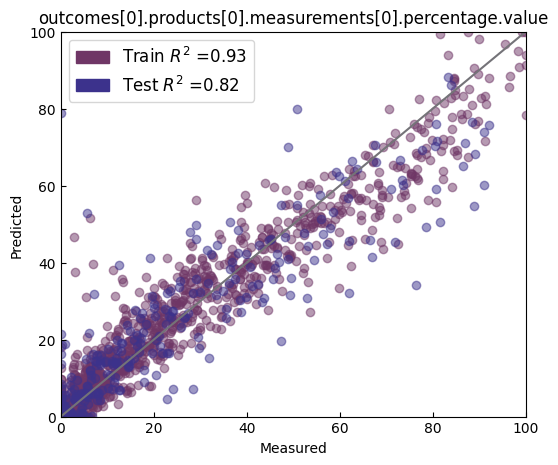

In [3]:
fig, ax = exp.parity_plot(include_test=True)
fig.savefig(f"{bdf.name}.png")

In [16]:
from summit import Runner
from summit.strategies import SOBO
# run virtual experiment campaigns

for acquisition_type in ["EI", "MPI"]:
    exp_new = ExperimentalEmulator.load(bdf.name, save_dir="./expt_emu_ds4")
    exp_new.X_train, exp_new.y_train, exp_new.X_test, exp_new.y_test = exp.X_train, exp.y_train, exp.X_test, exp.y_test
    strategy = SOBO(domain, gp_model_type="GP", acquisition_type=acquisition_type)
    runner = Runner(
        strategy, exp_new, num_initial_experiments=5, max_iterations=100
    )
    runner.run(progress_bar=True, save_freq=None, save_at_end=True, save_dir=f"expt_emu_ds4_al_{acquisition_type.lower()}")


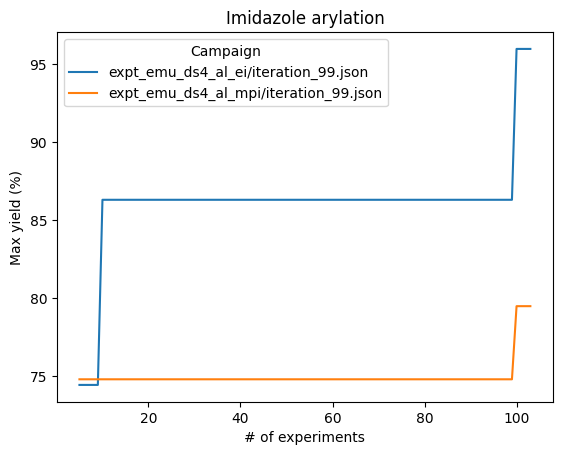

In [24]:
# plot results

import seaborn
import matplotlib.pyplot as plt
import json

def plot_campaign(data_files: list[str]):
    fig, ax = plt.subplots()
    ax.set_xlabel("# of experiments")
    ax.set_ylabel("Max yield (%)")
    ax.set_title("Imidazole arylation")
    for data_file in data_files:
        with open(data_file, "r") as f:
            data = json.load(f)
        his = [e[-4] for e in data['experiment']['data']['data']]
        xs = []
        ys = []
        for i in range(5, len(his)):
            yy = max(his[:i])
            xs.append(i)
            ys.append(yy)
        seaborn.lineplot(x=xs, y=ys, ax=ax, label=data_file)
    ax.legend(title="Campaign")
    fig.savefig("campaign.png")

plot_campaign([
    "expt_emu_ds4_al_ei/iteration_99.json",
    "expt_emu_ds4_al_mpi/iteration_99.json",
])
    